In [34]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D
from attention import Attention

In [30]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", 
                           filename="./data/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", 
                           filename="./data/ratings_test.txt")

('./data/ratings_test.txt', <http.client.HTTPMessage at 0x1ac88472d30>)

In [31]:
train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [66]:
train_data.info()
train_data.loc[train_data.document.isnull()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [67]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', regex=True)
train_data['document'].replace('', np.nan, inplace=True)
train_data.dropna(how='any', inplace=True)
train_data.info()
train_data['document'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


0

In [68]:
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', regex=True)
test_data['document'].replace('', np.nan, inplace=True)
test_data.dropna(how='any', inplace=True)
test_data.info()
test_data['document'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48298 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48298 non-null  int64 
 1   document  48298 non-null  object
 2   label     48298 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


0

In [69]:
y_train = train_data['label']
y_test = test_data['label']

train_data.drop(columns=['id', 'label'], inplace=True)
test_data.drop(columns=['id', 'label'], inplace=True)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   document  146182 non-null  object
dtypes: object(1)
memory usage: 6.3+ MB


In [70]:
docs = train_data['document'].values
docs_test = test_data['document'].values

print(docs)

token = Tokenizer()
token.fit_on_texts(docs)

['아 더빙   진짜 짜증나네요 목소리' '흠   포스터보고 초딩영화줄    오버연기조차 가볍지 않구나'
 '너무재밓었다그래서보는것을추천한다' ... '이게 뭐요  한국인은 거들먹거리고 필리핀 혼혈은 착하다 '
 '청춘 영화의 최고봉 방황과 우울했던 날들의 자화상' '한국 영화 최초로 수간하는 내용이 담긴 영화']


In [53]:
print(len(token.word_index))

283905


In [71]:
x = token.texts_to_sequences(docs)

In [58]:
maxidx = 0
for i in range(len(x)):
    if len(x[i]) > maxidx:
        maxidx = i
        
print(len(x[maxidx]))


47


In [72]:
padded_x = pad_sequences(x, 10)
print('패딩 결과 : ', padded_x[0:5])

패딩 결과 :  [[    0     0     0     0     0    24   924     4  6651  1094]
 [    0     0     0     0   630  6046 70277 70278  6984 30897]
 [    0     0     0     0     0     0     0     0     0 70279]
 [    0     0     0 24558 70280    73   368    29    30 10309]
 [  108  5290     1 70282 70283   868 24559 70284   589 70285]]


In [74]:
word_size = len(token.word_index) + 1

model = Sequential()
model.add(Embedding(word_size, 8, input_length=10))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 8)             2271248   
                                                                 
 flatten_2 (Flatten)         (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 2,271,329
Trainable params: 2,271,329
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(padded_x, y_train, epochs=20)

Epoch 1/20
4569/4569 [==============================] - 215s 47ms/step - loss: 0.4744 - accuracy: 0.7669
Epoch 2/20
4569/4569 [==============================] - 216s 47ms/step - loss: 0.2460 - accuracy: 0.9141
Epoch 3/20
 234/4569 [>.............................] - ETA: 3:24 - loss: 0.1271 - accuracy: 0.9595

KeyboardInterrupt: 

In [1]:
token.fit_on_texts(docs_test)
X_test = token.texts_to_sequences(docs)
padded_test = pad_sequences(X_test, 10)
print('Accuracy: %.4f' % (model.evaluate(padded_test, y_test)[1]))

NameError: name 'token' is not defined

### LSTM과 CNN 조합을 이용한

In [32]:
X_train = pd.read_table('./data/ratings_train.txt')
X_test = pd.read_table('./data/ratings_test.txt')

X_train.drop_duplicates(subset=['document'], inplace=True)
X_train['document'] = X_train['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', regex=True)
X_train['document'].replace('', np.nan, inplace=True)
X_train.dropna(how='any', inplace=True)

X_test.drop_duplicates(subset=['document'], inplace=True)
X_test['document'] = X_test['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', ' ', regex=True)
X_test['document'].replace('', np.nan, inplace=True)
X_test.dropna(how='any', inplace=True)

y_train = X_train['label']
y_test = X_test['label']

X_train.drop(columns=['id', 'label'], inplace=True)
X_test.drop(columns=['id', 'label'], inplace=True)

In [33]:
docs = X_train['document'].values

token = Tokenizer()
token.fit_on_texts(docs)
x = token.texts_to_sequences(docs)
word_size = len(token.word_index) + 1

In [36]:
model = Sequential()
model.add(Embedding(word_size, 50))
model.add(Dropout(0.5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55, return_sequences=True))
model.add(Attention())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 50)          14195300  
                                                                 
 dropout_5 (Dropout)         (None, None, 50)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, None, 64)          9664      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, None, 55)          26400     
                                                                 
 attention_1 (Attention)     (None, 128)               17105     
                                                      

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

X_train = pad_sequences(x, maxlen=50)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=40, validation_split=0.25, callbacks=[early_stop])

Epoch 1/100
2741/2741 [==============================] - 1216s 438ms/step - loss: 0.4567 - accuracy: 0.7662 - val_loss: 0.3830 - val_accuracy: 0.8197
Epoch 2/100
2741/2741 [==============================] - 1210s 441ms/step - loss: 0.2184 - accuracy: 0.9157 - val_loss: 0.4372 - val_accuracy: 0.8184
Epoch 3/100
2741/2741 [==============================] - 1200s 438ms/step - loss: 0.1024 - accuracy: 0.9633 - val_loss: 0.5483 - val_accuracy: 0.8102
Epoch 4/100
2741/2741 [==============================] - 1197s 437ms/step - loss: 0.0651 - accuracy: 0.9766 - val_loss: 0.6035 - val_accuracy: 0.8084
Epoch 5/100
2741/2741 [==============================] - 1190s 434ms/step - loss: 0.0487 - accuracy: 0.9821 - val_loss: 0.6585 - val_accuracy: 0.8022
Epoch 6/100
2741/2741 [==============================] - 1177s 429ms/step - loss: 0.0393 - accuracy: 0.9855 - val_loss: 0.7567 - val_accuracy: 0.8078


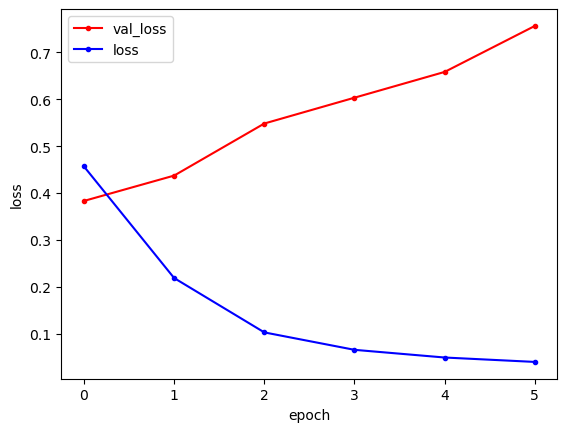

In [38]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_num = np.arange(len(y_vloss))

plt.plot(x_num, y_vloss, marker='.', c='red', label='val_loss')
plt.plot(x_num, y_loss, marker='.', c='blue', label='loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [40]:
docs = X_test['document'].values
print(docs)
token = Tokenizer()
token.fit_on_texts(docs)
sq_test = token.texts_to_sequences(docs)
X_test = pad_sequences(sq_test, maxlen=50)
model.evaluate(X_test, y_test)

['굳 ㅋ' '                    ' '뭐야 이 평점들은     나쁘진 않지만   점 짜리는 더더욱 아니잖아' ...
 '그림도 좋고 완성도도 높았지만    보는 내내 불안하게 만든다'
 '절대 봐서는 안 될 영화   재미도 없고 기분만 잡치고   한 세트장에서 다 해먹네' '마무리는 또 왜이래']
1537/1537 [==============================] - 8s 5ms/step - loss: 2.7468 - accuracy: 0.5039


[2.7468454837799072, 0.5038753151893616]

In [41]:
docs = '이 것도 영화라고 만들 었냐?'
token = Tokenizer()
token.fit_on_texts(docs)
sq_test = token.texts_to_sequences(docs)
X_test = pad_sequences(sq_test, maxlen=50)

model.predict(X_test)

1/1 [==============================] - 1s 701ms/step


array([[0.6032512 ],
       [0.6072927 ],
       [0.49437308],
       [0.534727  ],
       [0.6072927 ],
       [0.6010061 ],
       [0.599717  ],
       [0.28461775],
       [0.5436695 ],
       [0.6072927 ],
       [0.4752771 ],
       [0.6072927 ],
       [0.6072927 ],
       [0.5756068 ],
       [0.80738074],
       [0.6072927 ]], dtype=float32)